In [3]:
import os
import csv
import math
import copy
import random
import matplotlib
import numpy as np
from tcn import TCN
import pandas as pd
import tensorflow as tf
from numpy import array
from numpy import hstack
from plistlib import load
from algorithms.offline_opt import MIN
from algorithms.LFU import Bipartite_LFU
from keras.layers import LSTM
from algorithms.LRU import Bipartite_LRU
from keras.layers import Dense
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from algorithms.Lead_cache import Lead_cache
from scipy.optimize import minimize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from algorithms.Perturbed_LFU import Perturbed_Bipartite_LFU
from algorithms.Generate_network import generate_network_graph



matplotlib.rcParams['figure.figsize'] = (10, 7)
plt.plot()

ModuleNotFoundError: No module named 'Phi'

In [ ]:
users = 1
time_limit = float('inf')
caches = 1
alpha = 0.1
d = 1
# Dropping all file requests with id larger than the threshold to reduce the library size
threshold = 423
NumSeq = 150
run_lead = False

In [ ]:
path2 = f"./csv_{NumSeq}/"
try:
    os.makedirs(path2)
except FileExistsError:
    # directory already exists
    pass

### Lead cache

In [ ]:
if(run_lead):
  # denotes the number of non-overlapping sequences over which the experminent is run
    print("Users=", users, "caches=", caches, "Library_Size=", threshold, "time=", time_limit, "NumSeq=", NumSeq, file=open("parameters.log","w"))

    # generates a random network
    Adj = generate_network_graph(users, caches, d)

    # saves the network 
    print(Adj, file=open("network_adjacency_matrix.log", "w"))

    # Setting up the arrays to store hits and downloads over multiple runs
    LFU_Hits = []
    perturbed_LFU_Hits = []
    perturbed_LFU_Downloads = []
    LRU_Hits = []
    LeadCache_Hits = []
    LFU_Downloads = []
    LRU_Downloads = []
    LeadCache_Downloads = []
    OPT_Hits=[]
    OPT_Downloads = []
    LeadCache_Hits_Madow = []
    LeadCache_Downloads_Madow = []

    # Generating the request sequence
    #df=pd.read_csv('ratings.csv', sep=',',header=None)
    data = pd.read_csv("../Datasets/311_dataset.txt", sep = ' ')
    #data = pd.read_csv("sigmetrics_truncated_data.txt", sep = ' ')
    #data = pd.read_csv("ratings1m.dat", sep = '::')
    #data.columns = ['User_ID', 'File_ID', 'Ratings', 'Timestamp']
    data.columns = ['Timestamp', 'File_ID', 'File_Size']
    DataLength = len(data)
    # splitting up the entire time axis into non-overlapping parts
    for i in tqdm(range(NumSeq)):
        df = pd.DataFrame(data[int(i*DataLength/NumSeq) : int((i+1)*DataLength/NumSeq)])
        df.sort_values("Timestamp")

        #df= pd.DataFrame(data)

        # The Data is already sorted according to the Req_ID, so no need to sort it again
        # Renaming the annoynimized FileID's
        old_id = df.File_ID.unique()
        old_id.sort()
        new_id = dict(zip(old_id, range(len(old_id))))
        df = df.replace({"File_ID": new_id})
        df.sort_values("Timestamp")

        # Reducing the library size

        df = df[df.File_ID < threshold]
        df = df.reset_index(drop=True)

        library_size = df['File_ID'].max()+2
        C = math.floor(alpha*library_size)
        v = df['File_ID']
        RawSeq = np.array(v)
        print(np.max(v), len(v))
        time = int(np.floor(min(time_limit, len(v)/users)))-1
        print(time)
        # RawSeq contains an array of requests
        df = np.array_split(RawSeq, users)

        # Running the algorithms

        print("-"*50)
        print("Iter:", i, "/", NumSeq)
        hit_rates_OPT, download_rate_OPT = MIN(df, Adj, time, library_size, C)
        hit_rates_OPT = pd.DataFrame(hit_rates_OPT)
        download_rate_OPT = pd.DataFrame(download_rate_OPT)
        print("Min Completed")

        OPT_Hits.append(np.sum(hit_rates_OPT)/(time*users))
        OPT_Downloads.append(np.sum(download_rate_OPT)/(time*caches))

        hit_rates_LFU, download_rate_LFU = Bipartite_LFU(
            df, Adj, time, library_size, C)
        hit_rates_LFU = pd.DataFrame(hit_rates_LFU)
        download_rate_LFU = pd.DataFrame(download_rate_LFU)
        print("BLFU Completed")


        LFU_Hits.append(np.sum(hit_rates_LFU)/(time*users))
        LFU_Downloads.append(np.sum(download_rate_LFU)/(time*caches))

        hit_rates_LRU, download_rate_LRU = Bipartite_LRU(
            df, Adj, time, library_size, C)
        hit_rates_LRU = pd.DataFrame(hit_rates_LRU)
        download_rate_LRU = pd.DataFrame(download_rate_LRU)
        print("BLRU Completed")

        LRU_Hits.append(np.sum(hit_rates_LRU)/(time*users))
        LRU_Downloads.append(np.sum(download_rate_LRU)/(time*caches))

        hit_rates_Perturbed_LFU, download_rate_Perturbed_LFU = Perturbed_Bipartite_LFU(
            df, Adj, time, library_size, C, d)
        hit_rates_Perturbed_LFU = pd.DataFrame(hit_rates_Perturbed_LFU)
        download_rate_Perturbed_LFU = pd.DataFrame(download_rate_Perturbed_LFU)

        perturbed_LFU_Hits.append(np.sum(hit_rates_Perturbed_LFU)/(time*users))
        perturbed_LFU_Downloads.append(np.sum(download_rate_Perturbed_LFU)/(time*caches))
        print("PBLRU Completed")



        #print("Running LeadCache")

        hit_rates_Lead_cache, download_rate_Lead_cache, hit_rates_Madow, download_rates_Madow = Lead_cache(
            df, Adj, time, library_size, C, d)
        hit_rates_Lead_cache = pd.DataFrame(hit_rates_Lead_cache)
        download_rate_Lead_cache = pd.DataFrame(download_rate_Lead_cache)

        LeadCache_Hits.append(np.sum(hit_rates_Lead_cache)/(time*users))
        LeadCache_Downloads.append(np.sum(download_rate_Lead_cache)/(time*caches))

        hit_rates_Madow = pd.DataFrame(hit_rates_Madow)
        download_rates_Madow = pd.DataFrame(download_rates_Madow)

        LeadCache_Hits_Madow.append(np.sum(hit_rates_Madow)/(time*users))
        LeadCache_Downloads_Madow.append(np.sum(download_rates_Madow)/(time*caches))
        print("LC Completed")


        # #Outputting the result to stdout
        #print("LFU Hits=", LFU_Hits, "LRU Hits=", LRU_Hits, "OPT_Hits=", OPT_Hits, "Perturbed_LFU_Hits=", perturbed_LFU_Hits)
        #print("LFU Downloads=", LFU_Downloads, "LRU Downloads=", LRU_Downloads, "OPT_Downloads=", OPT_Downloads, "Perturbed_LFU_Downloads=", perturbed_LFU_Downloads)


    # Saving the output files

    pd.DataFrame(LFU_Hits).to_csv(path2+'LFU_Hits.csv',index=False)
    pd.DataFrame(LFU_Downloads).to_csv(path2+'LFU_Downloads.csv',index=False)
    pd.DataFrame(LRU_Hits).to_csv(path2+'LRU_Hits.csv',index=False)
    pd.DataFrame(LRU_Downloads).to_csv(path2+'LRU_Downloads.csv',index=False)
    pd.DataFrame(perturbed_LFU_Hits).to_csv(path2+'Perturbed_LFU_Hits.csv',index=False)
    pd.DataFrame(perturbed_LFU_Downloads).to_csv(path2+'Perturbed_LFU_Downloads.csv',index=False) 
    pd.DataFrame(LeadCache_Hits).to_csv(path2+'LeadCache_Hits.csv',index=False)
    pd.DataFrame(LeadCache_Downloads).to_csv(path2+'LeadCache_Downloads.csv',index=False) 
    pd.DataFrame(LeadCache_Hits_Madow).to_csv(path2+'LeadCache_Hits_Madow.csv',index=False)
    pd.DataFrame(LeadCache_Downloads_Madow).to_csv(path2+'LeadCache_Downloads_Madow.csv',index=False) 
    pd.DataFrame(OPT_Hits).to_csv(path2+'OPT_Hits.csv',index=False)
    pd.DataFrame(OPT_Downloads).to_csv(path2+'OPT_Downloads.csv',index=False)
        
    # Saving the dynamic hit-rate and download logs

    pd.DataFrame(hit_rates_OPT).to_csv(path2+'OPT_Hits_Seq.csv',index=False)
    pd.DataFrame(download_rate_OPT).to_csv(path2+'OPT_Downloads_Seq.csv',index=False)
    pd.DataFrame(hit_rates_LRU).to_csv(path2+'LRU_Hits_Seq.csv',index=False)
    pd.DataFrame(download_rate_LRU).to_csv(path2+'LRU_Downloads_Seq.csv',index=False)
    pd.DataFrame(hit_rates_LFU).to_csv(path2+'LFU_Hits_Seq.csv',index=False)
    pd.DataFrame(download_rate_LFU).to_csv(path2+'LFU_Downloads_Seq.csv',index=False)
    pd.DataFrame(hit_rates_Lead_cache).to_csv(path2+'LeadCache_Hits_Seq.csv',index=False)
    pd.DataFrame(download_rate_Lead_cache).to_csv(path2+'LeadCache_Downloads_Seq.csv',index=False)
    pd.DataFrame(perturbed_LFU_Hits).to_csv(path2+'perturbed_LFU_Hits_Seq.csv',index=False)
    pd.DataFrame(perturbed_LFU_Downloads).to_csv(path2+'perturbed_LFU_Downloads_Seq.csv',index=False)


In [ ]:
def get_delta():
    return 0.5
    # return np.random.uniform()

def split_sequences(sequences, ins, out):
    sequences = np.array(sequences)
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + ins
        out_end_ix = end_ix + out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def update_weight(model, demands):
    X, y = split_sequences(demands, past, future)
    model.fit(X, y, epochs=10, verbose=0)


def get_model(init_data, use_saved=False):
        if use_saved:
            try:
                print("Loaded Model ...")
                model = tf.keras.models.load_model('models/init.hdf5')
                return model
            except:
                pass
        else:
            print("Starting to make model ...")
            X, y = split_sequences(init_data, past, future)
            model = Sequential()
            model.add(LSTM(1024, activation='relu', input_shape=(past, threshold)))
            model.add(RepeatVector(future))
            model.add(LSTM(1024, activation='relu', return_sequences=True))
            model.add(LSTM(1024, activation='relu'))
            model.add(RepeatVector(future))
            model.add(LSTM(512, activation='relu', return_sequences=True))
            model.add(LSTM(256, activation='relu'))
            model.add(RepeatVector(future))
            model.add(LSTM(256, activation='relu', return_sequences=True))
            model.add(TimeDistributed(Dense(2*threshold)))
            model.add(TimeDistributed(Dense(threshold)))
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='mse')
            print("Model is compiled, starting to train model..")
            model.fit(X, y, epochs=20, verbose=0)
            print("Model fitting complete...")
            model.save("./models/init.hdf5")
        print("Model saved to ./models dir ...")
        return model

def predict_demand(model, demands):
    demands = np.array(demands)
    demands = demands.reshape((1, demands.shape[0], demands.shape[1]))
    predicted_demand = model.predict(demands, verbose=0)
    return predicted_demand[0][0]


def get_demands(seq_no, time_limit):
    df = pd.DataFrame(data[int(seq_no*DataLength/NumSeq) : int((seq_no+1)*DataLength/NumSeq)])
    df.sort_values("Timestamp")
    old_id = df.File_ID.unique()
    old_id.sort()
    new_id = dict(zip(old_id, range(len(old_id))))
    df = df.replace({"File_ID": new_id})
    df.sort_values("Timestamp")
    df = df[df.File_ID < threshold]
    df = df.reset_index(drop=True)
    v = df['File_ID']
    RawSeq = np.array(v)
    demand_count = np.zeros((threshold,))
    m_time = int(np.floor(min(time_limit, len(v))))-1
    for i in range(m_time):
        demand_count[RawSeq[i]]+=1
    return demand_count, m_time

In [ ]:
def constrained_solve(theta, C, nu, X_t_1, delta_t, Q_t, V, files):
    
    
    def objective(X):
        cache_hit = np.dot(theta, X)
        change = np.linalg.norm(X-X_t_1, ord=1)
        queue_term = Q_t*(change - nu)*delta_t
        return queue_term - V*cache_hit

    
    def greater_than_0(X):
        return X
    
    def less_than_1(X):
        return 1-X
    
    def cache_contraint(X):
        return C - np.sum(X)
    
    def solve():
        constraints = (
            {
                'type': 'ineq',
                'fun': cache_contraint
            },
            {
                'type': 'ineq',
                'fun': greater_than_0
            },
            {
                'type': 'ineq',
                'fun': less_than_1
            }
        )
        init = np.random.uniform(0, 1, size=(X_t_1.shape[0],))
        solution = minimize(objective, init, constraints=constraints)
        return solution
    
    def filter(X):
        indices = np.argsort(X)[::-1][:C]
        final = np.zeros((files,))
        final[indices] = 1
        return final
        
        
    X_sol = solve()
    return filter(X_sol["x"]), X_sol["fun"]`

In [ ]:
def constrained_solve_ftpl(theta, C, gamma, files, i):
    
    
    def objective(X):
        lr = math.sqrt(i/C)
        estimate = theta + gamma*lr
        return -np.dot(X, estimate)

    
    def greater_than_0(X):
        return X
    
    def less_than_1(X):
        return 1-X
    
    def cache_contraint(X):
        return C - np.sum(X)
    
    def solve():
        constraints = (
            {
                'type': 'ineq',
                'fun': cache_contraint
            },
            {
                'type': 'ineq',
                'fun': greater_than_0
            },
            {
                'type': 'ineq',
                'fun': less_than_1
            }
        )
        init = np.random.uniform(0, 1, size=(X_t_1.shape[0],))
        solution = minimize(objective, init, constraints=constraints)
        return solution
    
    def filter(X):
        indices = np.argsort(X)[::-1][:C]
        final = np.zeros((files,))
        final[indices] = 1
        return final
        
        
    X_sol = solve()
    return filter(X_sol["x"]), X_sol["fun"]

In [ ]:
data = pd.read_csv("../Datasets/311_dataset.txt", sep = ' ')
data.columns = ['Timestamp', 'File_ID', "File_Size"]
DataLength = len(data)

In [ ]:
train_memory = 5

Q = 0
V_0 = 500
cache_constraint = int(alpha*threshold)
cost_contraint = 20

use_saved = False

past = 3
future = 1

gamma = np.random.normal(0, 1, (threshold,))

In [ ]:
queue = []
err = []
objective = []
fetching_cost = []
cache_hit = []
prev_demands = []
best_maximum = []
hit_rate = []
download_rate = []


hit_rate_ftpl = []
download_rate_ftpl = []


X_t_1 = np.zeros((threshold,))
init_indices = random.sample(range(threshold), cache_constraint)
X_t_1[init_indices] = 1

X_t_1_ftpl = np.zeros((threshold,))
X_t_1_ftpl[init_indices] = 1

for i in tqdm(range(NumSeq)):
    V = 20
    next_dem, time = get_demands(i, time_limit)
    X_t = np.zeros((threshold,))
    init_indices = random.sample(range(threshold), cache_constraint)
    X_t[init_indices] = 1
    
    X_t_ftpl = np.zeros((threshold,))
    X_t_ftpl[init_indices] = 1
    if i==past+future:
        model = get_model(prev_demands, use_saved)
        print(model.summary())
        # pass
    elif i>past+future:
        to_train = prev_demands[max(0, i-train_memory):]
        update_weight(model, to_train)
        pred = predict_demand(model, prev_demands[i-past:])
        pred = np.maximum(pred, np.zeros((pred.size,)))
        pred = np.round(pred)
        np.array(prev_demands).mean(axis=0)
        # 
        
        # DPP Cache
        delta_t = get_delta()
        X_t, obj = constrained_solve(pred, cache_constraint, cost_contraint, X_t_1, delta_t, Q, V, threshold)
        objective.append(obj)
        Delta = delta_t*np.linalg.norm(X_t-X_t_1, ord=1)
        print(Delta)
        fetching_cost.append(Delta)
        
        # FTPL Cache
        # theta, C, X_t_1, gamma, files, i
        X_t_ftpl, obj_ftpl = constrained_solve_ftpl(np.array(prev_demands).sum(axis=0), cache_constraint, gamma, threshold, i)
        
        
        # Run the experiment on Next Demand DPP
        e = np.linalg.norm(next_dem-pred, ord=2)/len(pred)
        err.append(e)
        actual_cache_hit = np.dot(next_dem, X_t)
        cache_hit.append(actual_cache_hit)
        
        indices = np.argsort(next_dem)[::-1][:cache_constraint]
        final = np.zeros((threshold,))
        final[indices] = 1
        
        
        best = np.dot(next_dem, final)
        best_maximum.append(best)
        
        # Run the experiment on Next Demand FTPL
        
        
        Q = max(Q + Delta - cost_contraint, 0)
        queue.append(Q)
    
    # Metrics DPP
    hit_rate.append(np.dot(X_t, next_dem)/time)
    download_rate.append(np.sum(np.logical_and(X_t==1, X_t_1==0))/time)
    
    # Metrics FTPL
    hit_rate_ftpl.append(np.dot(X_t_ftpl, next_dem)/time)
    download_rate_ftpl.append(np.sum(np.logical_and(X_t_ftpl==1, X_t_1_ftpl==0))/time)
        
    X_t_1 = X_t
    X_t_1_ftpl = X_t_ftpl
    
    prev_demands.append(next_dem)

  0%|          | 0/150 [00:00<?, ?it/s]

Starting to make model ...
Model is compiled, starting to train model..
Model fitting complete...
Model saved to ./models dir ...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1024)              5931008   
                                                                 
 repeat_vector_9 (RepeatVect  (None, 1, 1024)          0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 1, 1024)           8392704   
                                                                 
 lstm_20 (LSTM)              (None, 1024)              8392704   
                                                                 
 repeat_vector_10 (RepeatVec  (None, 1, 1024)          0         
 tor)                                                   

In [ ]:
def ma(X, w=None):
    if(not w): w = len(X)
    avgs = []
    for i in range(len(X)):
        numer = np.sum(X[max(0, i-w+1):i+1])
        den = min(w, i+1)
        avgs.append(numer/den)
    return np.array(avgs)

In [ ]:
desc = "epoch+_mem+_past+"
path = f"./ours_{NumSeq}_{V_0}_{cost_contraint}_{desc}/"
try:
    os.makedirs(path)
except FileExistsError:
    # directory already exists
    pass

In [ ]:
pd.DataFrame(hit_rate).to_csv(path+'hit_rate.csv',index=False)
pd.DataFrame(download_rate).to_csv(path+'download_rate.csv',index=False)

pd.DataFrame(hit_rate_ftpl).to_csv(path+'hit_rate_ftpl.csv',index=False)
pd.DataFrame(download_rate_ftpl).to_csv(path+'download_rate_ftpl.csv',index=False)

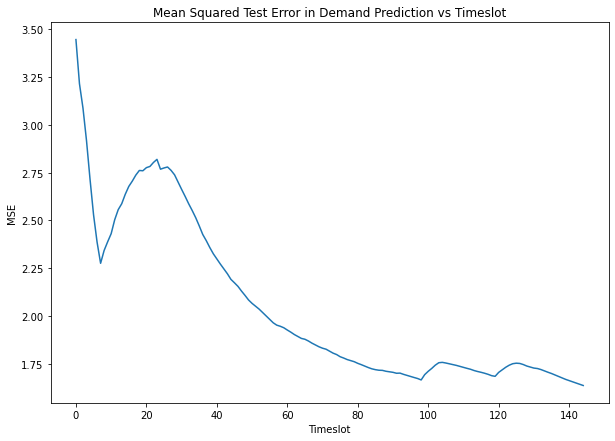

In [ ]:
plt.plot(ma(err))
plt.title("Mean Squared Test Error in Demand Prediction vs Timeslot")
plt.xlabel("Timeslot")
plt.ylabel("MSE")
plt.savefig(path+"NN-MSE.jpg")
plt.show()

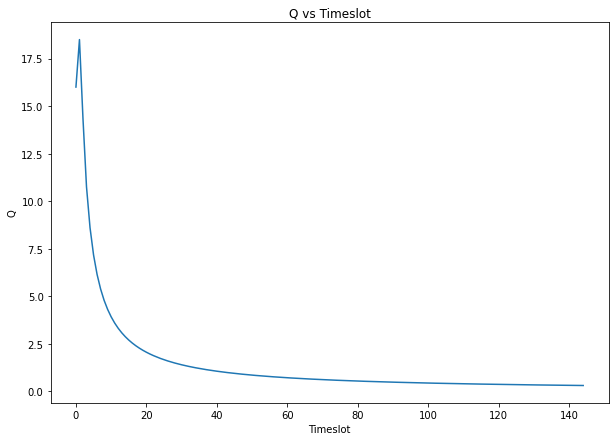

In [ ]:
plt.plot(ma(queue))
plt.title("Q vs Timeslot")
plt.xlabel("Timeslot")
plt.ylabel("Q")
plt.savefig(path+"Q.jpg")
plt.show()

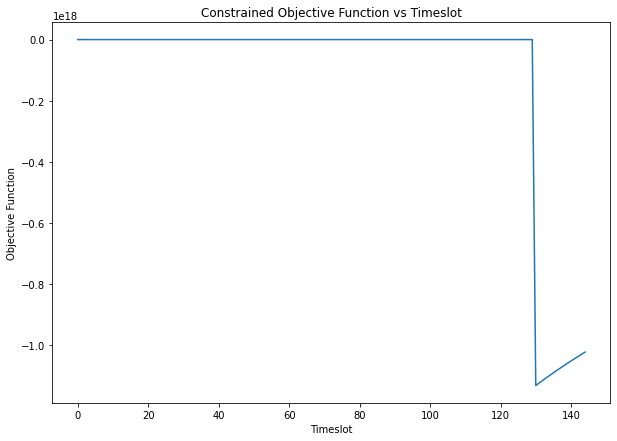

In [ ]:
plt.plot(ma(objective))
plt.title("Constrained Objective Function vs Timeslot")
plt.xlabel("Timeslot")
plt.ylabel("Objective Function")
plt.savefig(path+"Obj.jpg")
plt.show()

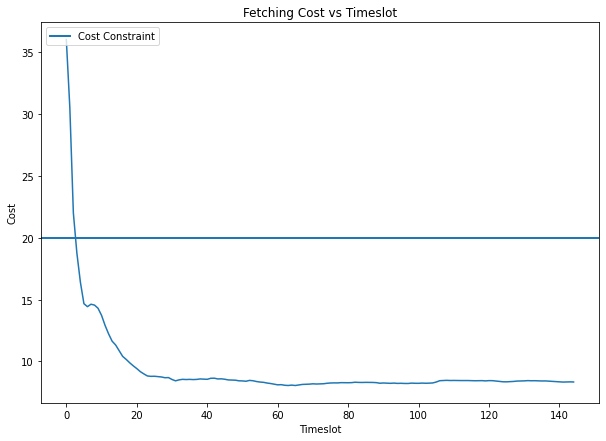

In [ ]:
plt.plot(ma(fetching_cost))
plt.title("Fetching Cost vs Timeslot")
plt.axhline(y=cost_contraint, linewidth=2, label= 'Cost Constraint')
plt.xlabel("Timeslot")
plt.ylabel("Cost")
plt.legend(loc = 'upper left')
plt.savefig(path+"Cost.jpg")
plt.show()

pd.DataFrame(ma(fetching_cost)).to_csv("cost_1.csv")

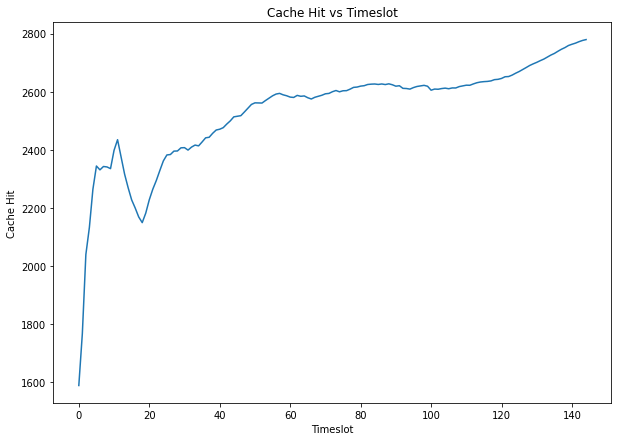

In [ ]:
plt.plot(ma(cache_hit))
plt.title("Cache Hit vs Timeslot")
plt.xlabel("Timeslot")
plt.ylabel("Cache Hit")
plt.savefig(path+"Cache_Hit.jpg")
plt.show()

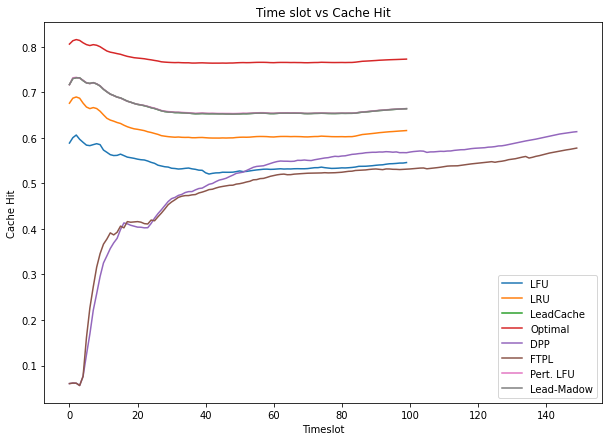

In [ ]:
path2 = path2.replace("150", "100")
lfu_hits = pd.read_csv(path2+"LFU_Hits.csv")
lru_hits = pd.read_csv(path2+"LRU_Hits.csv")
lead_hits = pd.read_csv(path2+"LeadCache_Hits.csv")
opt_hits = pd.read_csv(path2+"OPT_Hits.csv")
dpp_hits = pd.read_csv(path+"hit_rate.csv")
ftpl_hits = pd.read_csv(path+"hit_rate_ftpl.csv")
plfu_hits = pd.read_csv(path2+"perturbed_LFU_Hits.csv")
lead_hits_madow = pd.read_csv(path2+"LeadCache_Hits_Madow.csv")

plt.title("Time slot vs Cache Hit")
plt.xlabel("Timeslot")
plt.ylabel("Cache Hit")
plt.plot(ma(lfu_hits), label="LFU")
plt.plot(ma(lru_hits), label="LRU")
plt.plot(ma(lead_hits), label="LeadCache")
plt.plot(ma(opt_hits), label="Optimal")
plt.plot(ma(dpp_hits), label="DPP")
plt.plot(ma(ftpl_hits), label="FTPL")
plt.plot(ma(plfu_hits), label="Pert. LFU")
plt.plot(ma(lead_hits_madow), label="Lead-Madow")
plt.legend()
plt.savefig(path+"compare_hits.jpg")
plt.show()

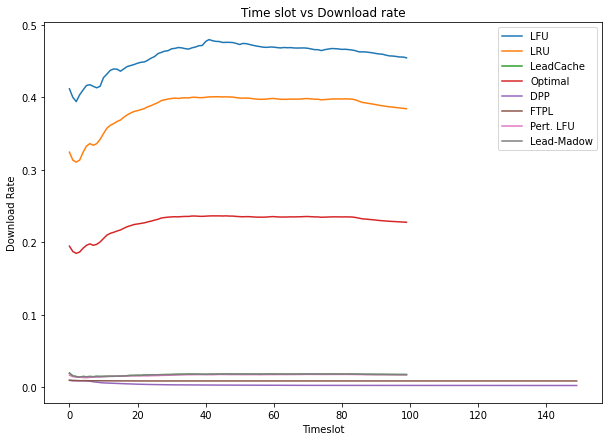

In [ ]:
lfu_downloads = pd.read_csv(path2+"LFU_Downloads.csv")
lru_downloads = pd.read_csv(path2+"LRU_Downloads.csv")
lead_downloads = pd.read_csv(path2+"LeadCache_Downloads.csv")
opt_downloads = pd.read_csv(path2+"OPT_Downloads.csv")
dpp_downloads = pd.read_csv(path+"download_rate.csv")
ftpl_downloads = pd.read_csv(path+"download_rate_ftpl.csv")
plfu_downloads = pd.read_csv(path2+"perturbed_LFU_Downloads.csv")
lead_downloads_madow = pd.read_csv(path2+"LeadCache_Downloads_Madow.csv")

plt.title("Time slot vs Download rate")
plt.xlabel("Timeslot")
plt.ylabel("Download Rate")
plt.plot(ma(lfu_downloads), label="LFU")
plt.plot(ma(lru_downloads), label="LRU")
plt.plot(ma(lead_downloads), label="LeadCache")
plt.plot(ma(opt_downloads), label="Optimal")
plt.plot(ma(dpp_downloads), label="DPP")
plt.plot(ma(ftpl_downloads), label="FTPL")
plt.plot(ma(plfu_downloads), label="Pert. LFU")
plt.plot(ma(lead_downloads_madow), label="Lead-Madow")
plt.legend()
plt.savefig(path+"compare_downloads.jpg")
plt.show()